In [1]:
import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')

from __init__ import *
from __init__jupyterlab import *
from scipy import sparse
import collections
import itertools
import re
import fbpca
import pickle
import scipy.cluster.hierarchy as sch
from sklearn.metrics import euclidean_distances

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_run_tsne
import CEMBA_clst_utils
import SCF_utils
importlib.reload(SCF_utils)

import seaborn as sns 
import matplotlib.pyplot as plt

# Configs  

In [2]:
config_dir = '/cndd/fangming/CEMBA/scripts/BICCN-Mouse-MOp/fig4' 
config_f = 'config_scf_11mods_it_200506.py' 
sys.path.insert(0, config_dir)
exec("from {} import *".format(config_f.split('.')[0]))

In [3]:
mods_selected = [
                 'smarter_cells',
                 '10x_cells_v3',
                 '10x_cells_v2',
                 'smarter_nuclei',
                 '10x_nuclei_v3_macosko',
                 '10x_nuclei_v3',
    
                 'snatac_gene',
                 'snmcseq_gene',
    
                 'patchseq',
                 'epi_retro', 
                 'merfish',
                ]

In [4]:
# fixed dataset configs
sys.path.insert(0, DATA_DIR)
import __init__datasets
importlib.reload(__init__datasets)
from __init__datasets import *

meta_f = os.path.join(DATA_DIR, '{0}_metadata.tsv')
hvftrs_f = os.path.join(DATA_DIR, '{0}_hvfeatures.{1}')
hvftrs_gene = os.path.join(DATA_DIR, '{0}_hvfeatures.gene')
hvftrs_cell = os.path.join(DATA_DIR, '{0}_hvfeatures.cell')

## Read in data 

In [5]:
log = snmcseq_utils.create_logger()
logging.info('*')

05/06/2020 12:05:09 AM *


In [6]:
metas = collections.OrderedDict()
for mod in mods_selected:
    meta = pd.read_csv(meta_f.format(mod), sep="\t").reset_index().set_index(settings[mod].cell_col)
    meta = meta.astype(dtype={settings[mod].annot_col: str})
    metas[mod] = meta
    print(mod, metas[mod].shape)

smarter_cells (2450, 129)
10x_cells_v3 (45075, 8)
10x_cells_v2 (63239, 8)
smarter_nuclei (2304, 146)
10x_nuclei_v3_macosko (59639, 19)
10x_nuclei_v3 (21813, 8)
snatac_gene (32967, 13)
snmcseq_gene (5339, 32)
patchseq (253, 115)
epi_retro (1110, 12)
merfish (112080, 15)


## All done, making plots after 

- Plotting packages

In [7]:
output_clst_and_umap

'/cndd/fangming/CEMBA/data/MOp_all/results/intg_summary_mop_11mods_it_200506.tsv'

In [8]:
# get results summary
mods_ordered = mods_selected 
assert set(mods_ordered) == set(mods_selected)

f = output_clst_and_umap

df_info = pd.read_csv(f, sep="\t", index_col='sample') 
df_info = df_info.rename({
                          'tsne_x': 'tsne_x_joint',
                          'tsne_y': 'tsne_y_joint',
                         }, axis=1)
df_info['modality_name'] = df_info['modality'].apply(lambda mod: settings[mod].name)

# add single-modality cluster, annot info
df_info['cluster'] = ''
df_info['annot'] = ''
for mod in mods_selected:
    _cells = metas[mod].index.values
    df_info.loc[_cells, 'cluster'] = metas[mod].loc[_cells, settings[mod].cluster_col]
    df_info.loc[_cells, 'annot'] = metas[mod].loc[_cells, settings[mod].annot_col]

# clean up annotation
df_info['annot'] = df_info['annot'].str.replace('_Glutamatergic', '')
df_info['annot'] = df_info['annot'].str.replace('_GABAergic', '')
df_info['annot'] = df_info['annot'].fillna(df_info['cluster'])

# get info
print(df_info.shape)
print(df_info.groupby('modality').size())
df_info.head()

(346269, 10)
modality
10x_cells_v2              63239
10x_cells_v3              45075
10x_nuclei_v3             21813
10x_nuclei_v3_macosko     59639
epi_retro                  1110
merfish                  112080
patchseq                    253
smarter_cells              2450
smarter_nuclei             2304
snatac_gene               32967
snmcseq_gene               5339
dtype: int64


,cluster_joint_r0.1,cluster_joint_r0.2,cluster_joint_r0.4,cluster_joint_r0.8,tsne_x_joint,tsne_y_joint,modality,modality_name,cluster,annot
sample,,,,,,,,,,
snmcseq_gene_2C_M_0,1,1,2,7,2.345971,-9.284725,snmcseq_gene,DNA methylation,L4-IT-Rorb_Rorb-Tenm2,L4-IT-Rorb_Rorb-Tenm2
snmcseq_gene_2C_M_1,2,2,1,1,4.103980,2.221154,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2
snmcseq_gene_2C_M_100,2,2,1,1,3.577672,3.489669,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2
snmcseq_gene_2C_M_1000,2,2,1,8,6.604176,7.755098,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2
snmcseq_gene_2C_M_1001,2,2,1,1,2.008680,3.267917,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2


In [9]:
# !cat '/cndd/fangming/CEMBA/data/MOp_all/results_final/cluster_annotation_scf_round3.tsv'
# !cat '/cndd/fangming/CEMBA/data/MOp_all/results_final/cluster_annotation_liger_level2.tsv'
# !head '/cndd/fangming/CEMBA/data/MOp_all/results_final/cell_cluster_assignment_all_integrations.tsv'

In [10]:
f = '/cndd/fangming/CEMBA/data/MOp_all/results_final/cluster_annotation_rna_consensus.tsv'
df_rna_annot = pd.read_csv(f, sep='\t', index_col=0)
def rename_rna(x):
    if x == -1:
        return np.nan
    else:
        return df_rna_annot.loc[int(x), 'annot']
    
f = '/cndd/fangming/CEMBA/data/MOp_all/results_final/cluster_annotation_scf_round3.tsv'
df_scf_annot = pd.read_csv(f, sep='\t', index_col=0)
def rename_scf_r3(x):
    if x == -1:
        return np.nan
    else:
        return df_scf_annot.loc[x, 'annot']
    
def rename_liger(x):
    if x == -1:
        return np.nan
    else:
        return x
    
#     elif x in ['non_it_4', 'non_it_9']:
#         return x+' (PT)' 
#     else:
#         return x
    

f = '/cndd/fangming/CEMBA/data/MOp_all/results_final/cell_cluster_assignment_all_integrations.tsv'
df_info2 = pd.read_csv(f, sep='\t', index_col=0)
df_info2['RNA concensus'] = df_info2['RNA concensus'].fillna(-1).apply(rename_rna)
df_info2['SCF_round3'] = df_info2['SCF_round3'].fillna(-1).apply(rename_scf_r3)
df_info2['LIGER_level2'] = df_info2['LIGER_level2'].fillna(-1).apply(rename_liger)

df_info = df_info.join(df_info2.drop('modality', axis=1))
df_info.head()

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cluster_joint_r0.1,cluster_joint_r0.2,cluster_joint_r0.4,cluster_joint_r0.8,tsne_x_joint,tsne_y_joint,modality,modality_name,cluster,annot,SCF_round2,SCF_round3,RNA concensus,LIGER_level1,LIGER_level2
sample,,,,,,,,,,,,,,,
snmcseq_gene_2C_M_0,1,1,2,7,2.345971,-9.284725,snmcseq_gene,DNA methylation,L4-IT-Rorb_Rorb-Tenm2,L4-IT-Rorb_Rorb-Tenm2,1-1,L4/5 IT (1),NaN,0,it_8
snmcseq_gene_2C_M_1,2,2,1,1,4.103980,2.221154,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4-2,L2/3 IT (3),NaN,1,it_0
snmcseq_gene_2C_M_100,2,2,1,1,3.577672,3.489669,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4-1,L2/3 IT (1),NaN,1,it_0
snmcseq_gene_2C_M_1000,2,2,1,8,6.604176,7.755098,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4-2,L2/3 IT (3),NaN,1,it_0
snmcseq_gene_2C_M_1001,2,2,1,1,2.008680,3.267917,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4-1,L2/3 IT (1),NaN,1,it_0


In [41]:
joint_cluster = 'cluster_joint_r0.2'

# mod colors and names
mod_colors = collections.OrderedDict({mod: settings[mod].color for mod in mods_ordered})
mod_names = {mod: settings[mod].name for mod in mods_ordered}

# get cluster centroids
centroids = {}
_x = (df_info[['tsne_x_joint', 'tsne_y_joint', 'annot', 'modality']]
             .groupby(['modality', 'annot']).median())
for mod in mods_selected:
    centroids[mod] = _x.loc[mod, :]
centroids['joint'] = (df_info[['tsne_x_joint', 'tsne_y_joint', joint_cluster]]
             .groupby([joint_cluster]).median())

# get annotation for joint clusters 
joint_annot = df_info[df_info['modality'].isin(features_selected)].groupby([joint_cluster]).agg({'annot': lambda x: x.value_counts().index.values[0]})

# get uniq colors for joint clusters  
clsts = np.sort(df_info[joint_cluster].unique())
colors = snmcseq_utils.gen_colors(len(clsts))
joint_clst_colors = {clst: color for clst, color in zip(clsts, colors)}

# histograms
hist = df_info.groupby([joint_cluster, 'modality']).size().unstack().fillna(0).astype(int)
hist_mod = hist.sum(axis=0)
hist_clst = hist.sum(axis=1)

hist_frac = hist.divide(hist_clst, axis=0)
hist_exp = pd.DataFrame(np.outer(hist_clst/hist_clst.sum(), hist_mod), 
             index=hist_clst.index, columns=hist_mod.index.values)
hist_enrich = (hist+1)/(hist_exp+1)

In [42]:
def plot_1():
    from matplotlib.gridspec import GridSpec

    sample_n = min(len(df_info), 20000)
    n_resolutions = len(resolutions)
    fig = plt.figure(figsize=(8*2,6*2))
    gs = GridSpec(2, n_resolutions)

    ax = fig.add_subplot(gs[0, :])
    kw_colors = {settings[mod].name: settings[mod].color for mod in mods_ordered}
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                      legend_kws=legend_kws,
                                      kw_colors=kw_colors,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')

    layouts = [(1, i) for i in range(n_resolutions)]
    for resolution, layout in zip(resolutions, layouts):
        ax = fig.add_subplot(gs[layout[0], layout[1]])
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster_joint_r{}'.format(resolution)
        snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                          legend_mode=-1,
                                          sample_n=sample_n,
                                          rasterized=True,
                                          s=2,
                                         )
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title('{} joint clusters (r={})'.format(len(df_info[tc].unique()), resolution))

    fig.tight_layout()
    fig.savefig(output_figures.format('plot_0', 'pdf'), bbox_inches='tight', dpi=300)
    plt.show()

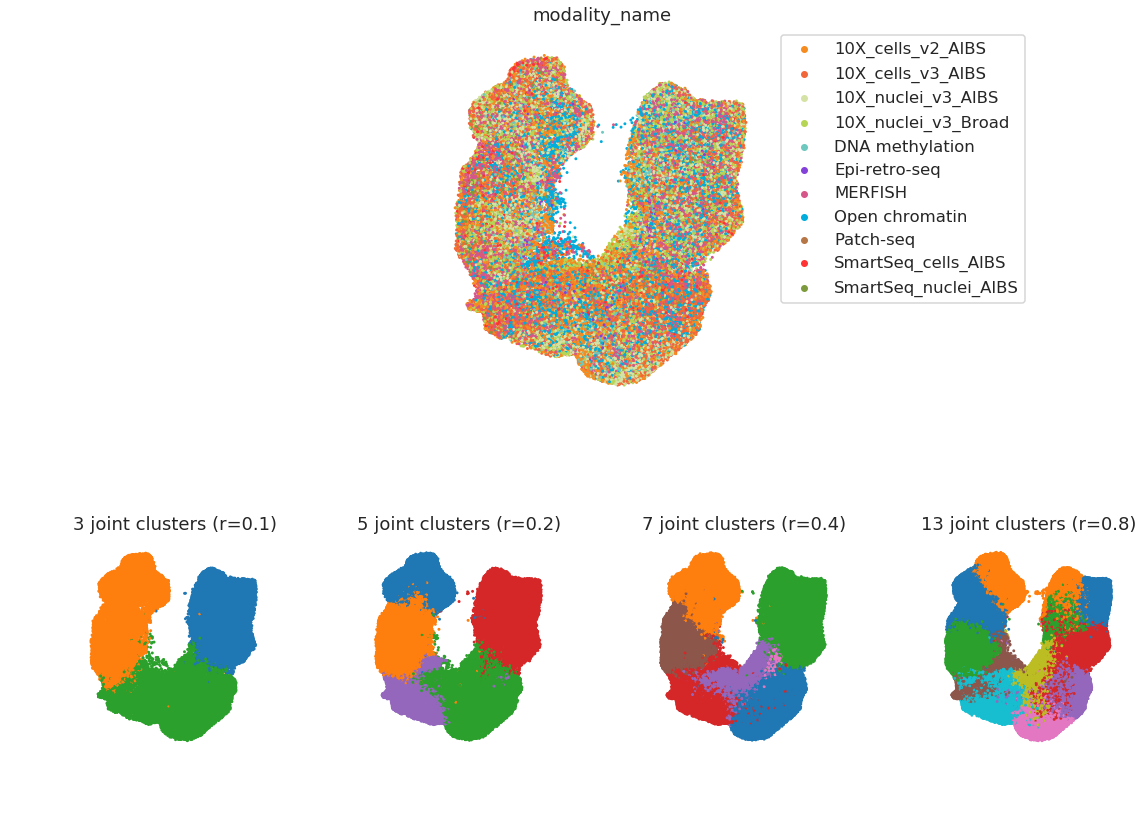

In [43]:
plot_1()

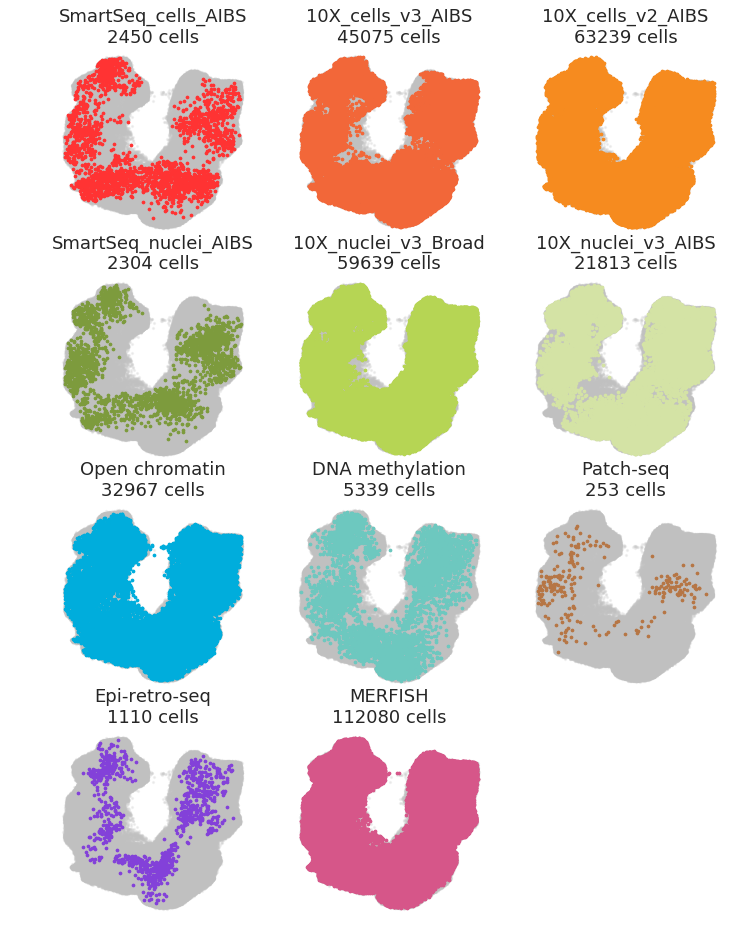

In [44]:
n = len(mods_selected)
nx = 3
ny = int((n+nx-1)/nx)
    
fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny))
axs = axs.flatten()
for mod, ax in zip(mods_ordered, axs):
    ax.scatter(df_info['tsne_x_joint'].values, 
                df_info['tsne_y_joint'].values, 
                s=3,
                alpha=0.2,
                rasterized=True,
                color='silver')
    ax.scatter(df_info.loc[df_info['modality']==mod, 'tsne_x_joint'].values, 
                df_info.loc[df_info['modality']==mod, 'tsne_y_joint'].values, 
                s=5,
                alpha=1,
                rasterized=True,
                color=settings[mod].color)
    ax.set_title("{}\n{} cells".format(settings[mod].name, len(df_info[df_info['modality']==mod])))
    ax.axis('off')

for ax in axs[n:]:
    ax.axis('off')

fig.savefig(output_figures.format('plot_n0', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [45]:

# fracs = [0.01, 0.02, 0.05, 
#         0.1, 0.2, 0.5,
#         1,
#        ]
# n = len(fracs)

# fig, axs = plt.subplots(1, n, figsize=(n*5, 1*5))
# for frac, ax in zip(fracs, axs):
#     ax.set_title("frac={}".format(frac))
#     df_info_sub = df_info.sample(frac=frac)
#     ax.hexbin(df_info_sub['tsne_x_joint'], 
#               df_info_sub['tsne_y_joint'], 
#               cmap='rocket_r',
#               )
#     ax.set_aspect('equal')
#     ax.axis('off')
# plt.show()


In [46]:
# fracs = [0.01, 0.02, 0.05, 
#         0.1, 0.2, 0.5,
#         1,
#        ]
# n = len(fracs)
# n0 = len(mods_selected)

# fig, axs = plt.subplots(n0, n, figsize=(n*5, n0*5))
# for i, mod in enumerate(mods_selected):
#     _x = df_info[df_info['modality']==mod]
#     for j, frac in enumerate(fracs):
#         ax = axs[i, j]
#         df_info_sub = _x.sample(frac=frac)
#         ax.hexbin(df_info_sub['tsne_x_joint'], 
#                   df_info_sub['tsne_y_joint'], 
#                   cmap='rocket_r',
#                   rasterized=True,
#                   )
#         ax.set_aspect('equal')
#         ax.axis('off')
#         if j == 0:
#             ax.set_title("{} frac={}".format(settings[mod].name, frac))
#         else:
#             ax.set_title("frac={}".format(frac))
# snmcseq_utils.savefig(fig, output_figures.format('density_dowmsampled', 'pdf'))
# plt.show()


In [47]:
# n = len(mods_selected)
# nx = 3
# ny = int((n+nx-1)/nx)

# n_subs = [100, 200, 500, 
#           1000, 2000, 5000, 
#           10000, 20000, 50000, 
#           100000]
# for n_sub in n_subs:
#     df_info_sub = df_info.groupby('modality', group_keys=False).apply(lambda x: x.sample(min(len(x), n_sub)))
#     print(n_sub)

#     fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny))
#     axs = axs.flatten()
#     for mod, ax in zip(mods_ordered, axs):
#         ax.scatter(df_info_sub['tsne_x_joint'].values, 
#                     df_info_sub['tsne_y_joint'].values, 
#                     s=3,
#                     alpha=0.2,
#                     rasterized=True,
#                     color='silver')
#         ax.scatter(df_info_sub.loc[df_info_sub['modality']==mod, 'tsne_x_joint'].values, 
#                     df_info_sub.loc[df_info_sub['modality']==mod, 'tsne_y_joint'].values, 
#                     s=5,
#                     alpha=1,
#                     rasterized=True,
#                     color=settings[mod].color)
#         ax.set_title("{}\n{} cells".format(settings[mod].name, len(df_info_sub[df_info_sub['modality']==mod])))
#         ax.axis('off')

#     for ax in axs[n:]:
#         ax.axis('off')

#     fig.savefig(output_figures.format('plot_n0_sub{}'.format(n_sub), 'pdf'), bbox_inches='tight', dpi=300)
#     plt.show()

In [99]:
df_info.groupby(['modality', 'cluster']).first()['annot']
pt_cond = df_info['annot'].str.contains(r'IT|L2/3|L4|^E[0-9]|L23')
print(df_info.shape)
print(df_info[pt_cond].shape)

import re
pt_pattern = re.compile(r"(.*IT|^E[0-9]|L2/3|L4|^it_)")
print(pt_pattern.match('ET-3'), pt_pattern.match('T'), pt_pattern.match("it_1"))

(346269, 15)
(346140, 15)
None None <_sre.SRE_Match object; span=(0, 3), match='it_'>


In [49]:
df_info['annot'].unique()

array(['L4-IT-Rorb_Rorb-Tenm2', 'L23-IT-Cux2', 'L4-IT-Rorb_Rorb-Ryr3',
       'L4-IT-Rorb_Rorb-Cpne4', 'L6-IT-Sulf1_Cables1', 'L5-IT-Deptor',
       'L6-IT-Sulf1_Meis2', 'Outlier', 'L6-IT-Sulf1_Sulf1', 'L23.b',
       'L5.IT.b', 'L4', 'L5.IT.a', 'L23.a', 'L6.IT', 'L23.c',
       'L5 IT S100b_2', 'L5 IT Rspo1', 'L5 IT Rspo2', 'L5 IT S100b_1',
       'L5 IT Tcap_1', 'L2/3 IT Macc1', 'L2/3 IT S100a6',
       'L2/3 IT Cdh13 Sla', 'L6 IT Sulf_1', 'L6 IT Sulf_3', 'L5 IT Tcap_2',
       'L6 IT Sulf_2', 'L5 IT Pld5', 'L2/3 IT', 'L5 IT Rspo1_1',
       'L6 IT Fos', 'L5 IT Rspo1_2', 'L5 ET_1', 'L5 IT Rspo2_1',
       'L5 IT S100b', 'L2/3 IT ', 'L6 IT_2', 'L6 IT_1', 'L6 IT Sulf1_4',
       'L6 CT Cpa6_2', 'L6 CT Cpa6_1', 'L6 IT Sulf1_3', 'L6 IT Sulf1_1',
       'L6 IT Sulf1_2', 'L5 ET_2', 'L6b Shisa6', 'L6 CT Brinp3',
       'L5 IT Rspo1_3', 'L2/3 IT_2', 'L2/3 IT_1', 'L2/3 IT_3',
       'L5 IT Pld5_2', 'L5 IT Pld5_1', 'L6b Ror1', 'L5 ET_4',
       'L6 IT Sulf1 Fos', 'L23_IT_3', 'L45_IT_1', 'L45_I

In [50]:
df_info.loc[~pt_cond, 'annot'].unique()

array(['Outlier', 'L23.b', 'L23.a', 'L23.c', 'L5 ET_1', 'L6 CT Cpa6_2',
       'L6 CT Cpa6_1', 'L5 ET_2', 'L6b Shisa6', 'L6 CT Brinp3', 'L6b Ror1',
       'L5 ET_4'], dtype=object)

In [51]:
np.array([clst for clst in df_info['annot'].unique() if not pt_pattern.match(clst)])

array(['Outlier', 'L23.b', 'L23.a', 'L23.c', 'L5 ET_1', 'L6 CT Cpa6_2',
       'L6 CT Cpa6_1', 'L5 ET_2', 'L6b Shisa6', 'L6 CT Brinp3', 'L6b Ror1',
       'L5 ET_4'],
      dtype='<U12')

In [52]:
df_info.loc[~pt_cond, 'modality'].value_counts()

snatac_gene              15024
snmcseq_gene               110
10x_cells_v3                12
10x_nuclei_v3                4
10x_nuclei_v3_macosko        2
smarter_nuclei               1
Name: modality, dtype: int64

In [53]:
df_info.loc[~pt_cond].groupby(['modality', 'cluster']).size()

modality               cluster
10x_cells_v3           51            7
                       60            3
                       61            2
10x_nuclei_v3          54            1
                       59            1
                       60            2
10x_nuclei_v3_macosko  56            1
                       59            1
smarter_nuclei         32            1
snatac_gene            L23.a      5938
                       L23.b      5602
                       L23.c      3484
snmcseq_gene           Outlier     110
dtype: int64

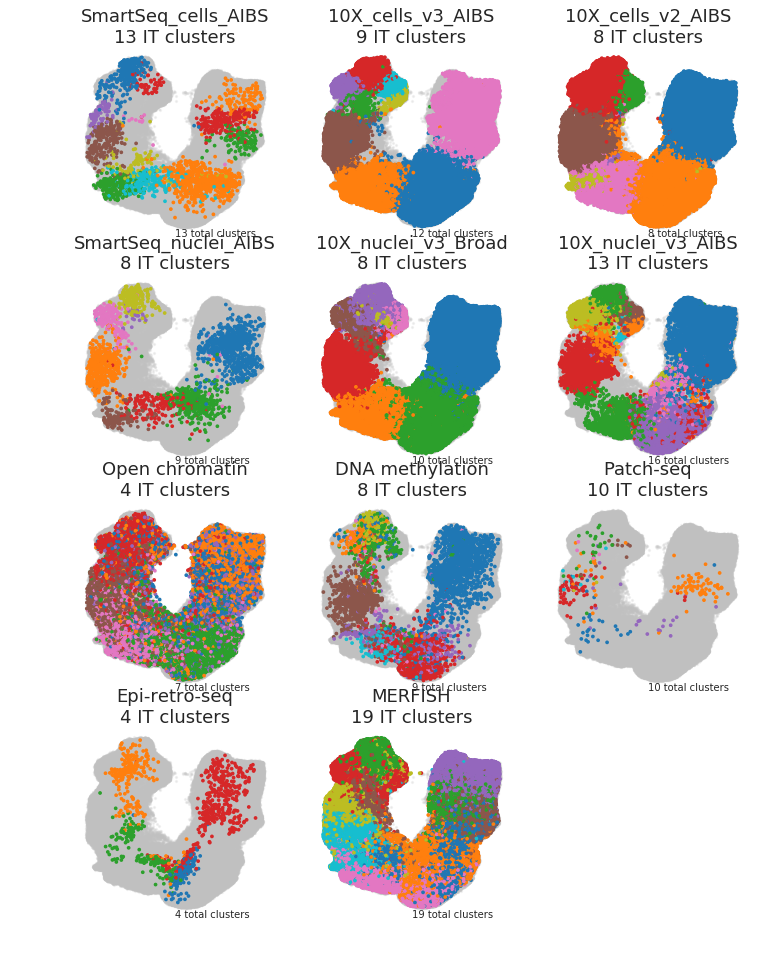

In [54]:
n = len(mods_selected)
nx = 3
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny))
axs = axs.flatten()
for mod, ax in zip(mods_ordered, axs):
    ax.scatter(df_info['tsne_x_joint'].values, 
                df_info['tsne_y_joint'].values, 
                s=3,
                alpha=0.2,
                rasterized=True,
                color='silver')
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster'
    snmcseq_utils.plot_tsne_labels_ax(df_info[df_info['modality']==mod], ax, tx, ty, tc, 
                                      t_xlim=None, t_ylim=None,
                                      legend_mode=-1,
                                      rasterized=True,
                                      s=5,
                                     )
    ax.set_title('{}\n{} IT clusters'.format(settings[mod].name, 
                                          len(df_info.loc[((df_info['modality']==mod) & (pt_cond)), tc].unique()), 
                                         ))
    ax.text(0.5, 0.0, "{} total clusters".format(len(df_info.loc[df_info['modality']==mod, tc].unique())), 
            transform=ax.transAxes,
           )
    ax.axis('off')

for ax in axs[n:]:
    ax.axis('off')

fig.savefig(output_figures.format('plot_n1_nolabel', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [93]:
output_figures

'/cndd/fangming/CEMBA/data/MOp_all/results/figures/mop_11mods_it_200506_{}.{}'

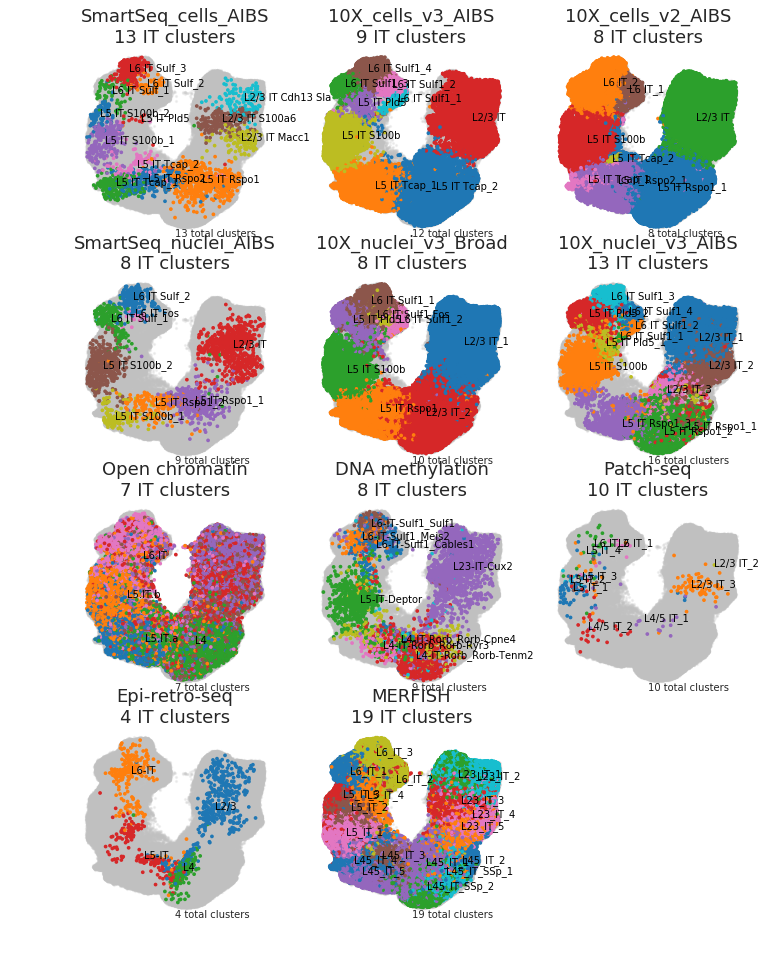

In [102]:
n = len(mods_selected)
nx = 3
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny))
axs = axs.flatten()
for mod, ax in zip(mods_ordered, axs):
    ax.scatter(df_info['tsne_x_joint'].values, 
                df_info['tsne_y_joint'].values, 
                s=3,
                alpha=0.2,
                rasterized=True,
                color='silver')
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster'
    snmcseq_utils.plot_tsne_labels_ax(df_info[df_info['modality']==mod], ax, tx, ty, tc, 
                                      t_xlim=None, t_ylim=None,
                                      legend_mode=-1,
                                      rasterized=True,
                                      s=5,
                                     )
    ax.set_title('{}\n{} IT clusters'.format(settings[mod].name, 
                                          len(df_info.loc[((df_info['modality']==mod) & (pt_cond)), tc].unique()), 
                                         ))
    ax.text(0.5, 0.0, "{} total clusters".format(len(df_info.loc[df_info['modality']==mod, tc].unique())), 
            transform=ax.transAxes,
           )
    ax.axis('off')
    
    for clst, centroid in centroids[mod].iterrows():
        if pt_pattern.match(clst):
            ax.text(centroid.values[0], 
                    centroid.values[1], 
                    clst,
                    color='black', 
                    fontsize=10,
                   )

for ax in axs[n:]:
    ax.axis('off')

fig.savefig(output_figures.format('plot_n1_label', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [56]:
proj_colors = collections.OrderedDict({
    'ACA': 'C0',
    'SSp': 'C1',
    'STR': 'C2',
    'TH': 'black',
    'SC': 'black',
    'Pons': 'black',
    'MB': 'black',
    'MY': 'black',
})
targets = list(proj_colors.keys())
targets

['ACA', 'SSp', 'STR', 'TH', 'SC', 'Pons', 'MB', 'MY']

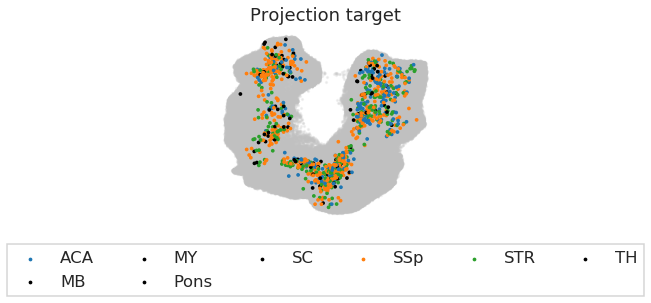

In [57]:
mod = 'epi_retro'
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(df_info['tsne_x_joint'].values, 
            df_info['tsne_y_joint'].values, 
            s=3,
            alpha=0.2,
            rasterized=True,
            color='silver')

tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'Target'
df = metas['epi_retro'].join(df_info)
snmcseq_utils.plot_tsne_labels_ax(df, ax, tx, ty, tc, 
                                  t_xlim=None, t_ylim=None,
                                  rasterized=True,
                                  legend_mode=1,
                                  kw_colors=proj_colors,
                                  s=5,
                                 )

ax.set_title('Projection target') 
ax.axis('off')


fig.savefig(output_figures.format('plot_n5_projection', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [58]:
x = df.groupby(['Target', joint_cluster]).size().unstack().fillna(0).astype(int)
x.sum(axis=1)

Target
ACA     233
MB       33
MY        8
Pons     22
SC       16
SSp     496
STR     279
TH       23
dtype: int64

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


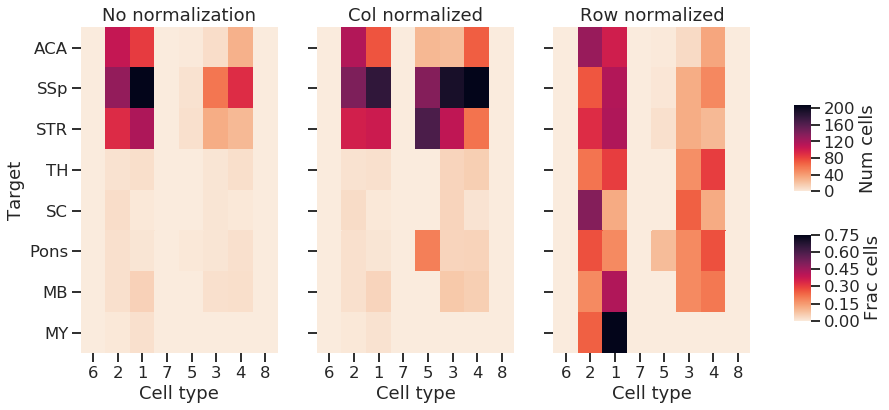

In [59]:
conf_mat = x.loc[targets, 
#                  [1, 2, 3, 6, 4, 7, 5], 
#                  [6, 4, 1, 7, 2, 3, 5,], 
#                  [6, 1, 4, 2, 3, 5, 7,], 
#                  [6, 1, 4, 7, 2, 3, 5,], 
#                  :,
                 [6, 2, 1, 7, 5, 3, 4, 8],
                ]

fig, axs = plt.subplots(1, 3, figsize=(4*3,6), sharey=True)
cbar_ax0 = fig.add_axes([0.95, 0.5, 0.02, 0.2])
cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.2])
ax = axs[0]
sns.heatmap(conf_mat.fillna(0), 
#             yticklabels=["{}_{}".format(y, annot2.loc[y, 'annotation_curated']) for y in conf_mat.index],
            cbar=True,
            cbar_ax=cbar_ax0,
            cmap='rocket_r',
            cbar_kws={'label': 'Num cells'},
            ax=ax,
            )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_title('No normalization')
ax.set_xlabel('Cell type')
ax.set_ylabel('Target')
ax = axs[1]
sns.heatmap(conf_mat.divide(conf_mat.sum(axis=0), axis=1).fillna(0), 
#             yticklabels=["{}_{}".format(y, annot2.loc[y, 'annotation_curated']) for y in conf_mat.index],
            cbar=False,
            cmap='rocket_r',
            ax=ax,
            )
ax.set_title('Col normalized')
ax.set_xlabel('Cell type')
ax.set_ylabel('')
ax = axs[2]
sns.heatmap(conf_mat.divide(conf_mat.sum(axis=1), axis=0).fillna(0), 
#             yticklabels=["{}_{}".format(y, annot2.loc[y, 'annotation_curated']) for y in conf_mat.index],
            cmap='rocket_r',
            cbar_ax=cbar_ax,
            cbar_kws={'label': 'Frac cells'},
            ax=ax,
            )
ax.set_title('Row normalized')
ax.set_xlabel('Cell type')
ax.set_ylabel('')
snmcseq_utils.savefig(fig, output_figures.format('plot_n4_heatmap_projection', 'pdf'))
plt.show()

In [60]:
def plot_1_single(kw_colors='', show_labels=False, output=''):
    """plot umap cluster 
    """
    fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', joint_cluster
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                         #  legend_kws=legend_kws,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      kw_colors=kw_colors,
                                      legend_mode=-1,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')
    if show_labels:
        for clst, centroid in centroids['joint'].iterrows():
            facecolor='white'
            ax.text(centroid.values[0], 
                    centroid.values[1], 
#                     str(clst)+'_'+joint_annot.loc[clst, 'annot'],
                    str(clst),
                    color='black', 
                    bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                    fontsize=25,
                   )

    fig.savefig(output, bbox_inches='tight', dpi=300)
    plt.show()
        
def plot_2_single(output=''):
    """Plot umap - modality
    """
    fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
    kw_colors = {settings[mod].name: settings[mod].color for mod in mods_selected}
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                      legend_kws=legend_kws,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      kw_colors=kw_colors,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')

    fig.savefig(output, bbox_inches='tight', dpi=300)
    plt.show()

def plot_3(output='', 
           show_labels=False):
    """Plot umap - cluster - each modality
    """
    n = len(mods_selected)
    nx = 3
    ny = int((n+nx-1)/nx)
    fig, axs = plt.subplots(ny, nx, figsize=(6*nx,6*ny))
    axs = axs.flatten()
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster'

    for ax, mod in zip(axs, mods_selected):
        snmcseq_utils.plot_tsne_labels_ax(df_info[df_info['modality']==mod], ax, tx, ty, tc, 
                                          sample_n=sample_n,
                                          legend_mode=-1,
                                          rasterized=True,
                                          s=2,
                                         )
        ax.set_title('{} ({} clusters)'.format(settings[mod].name, len(df_info.loc[df_info['modality']==mod, tc].unique())))
    
        if show_labels:
            for clst, centroid in centroids[mod].iterrows():
                facecolor='white'
                ax.text(centroid.values[0], 
                        centroid.values[1], 
                        clst,
                        color='black', 
                        bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                        fontsize=10,
                       )
        ax.set_aspect('equal')
        ax.axis('off')
    for ax in axs[n:]:
        ax.axis('off')


    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    fig.savefig(output, bbox_inches='tight', dpi=300)
    plt.show()


In [61]:
joint_clst_colors

{1: '#d75c5c', 2: '#bed75c', 3: '#5cd78d', 4: '#5c8dd7', 5: '#be5cd7'}

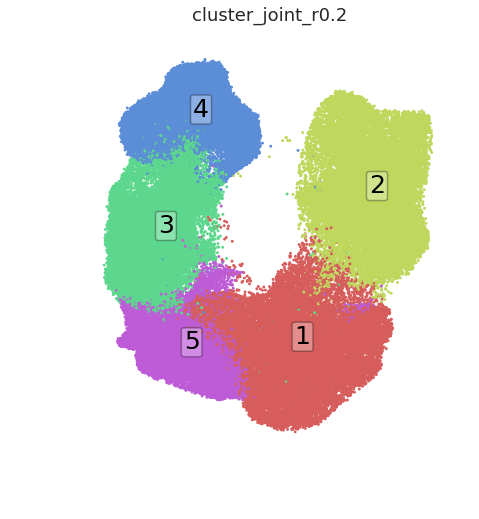

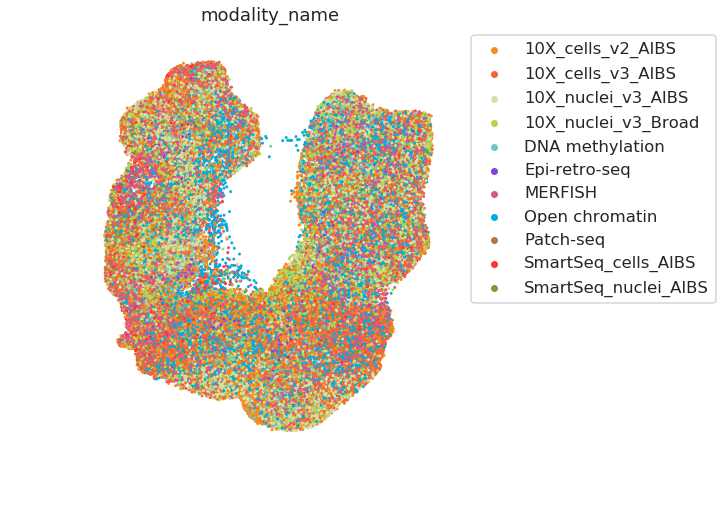

In [62]:
sample_n = 20000
# umap cluster
plot_1_single(joint_clst_colors, show_labels=True, output=output_figures.format('plot_1-label', 'pdf'))
# plot_1_single(joint_clst_colors, show_labels=False, output=output_figures.format('plot_1-nolabel', 'pdf'))
plot_2_single(output=output_figures.format('plot_2-nolabel', 'pdf'))

In [63]:
def plot_1_single_v2(tc, cluster_centroids, kw_colors='', show_labels=False, output=''):
    """plot umap cluster 
    """
    fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', tc 
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    snmcseq_utils.plot_tsne_labels_ax(df_plot, ax, tx, ty, tc, 
                                         #  legend_kws=legend_kws,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      kw_colors=kw_colors,
                                      legend_mode=-1,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')
    if show_labels:
        for clst, centroid in cluster_centroids.iterrows():
            if pt_pattern.match(clst):
                facecolor='white'
                ax.text(centroid.values[0], 
                        centroid.values[1], 
                        str(clst),
                        color='black', 
                        bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                        fontsize=15,
                       )

    fig.savefig(output, bbox_inches='tight', dpi=300)
    plt.show()

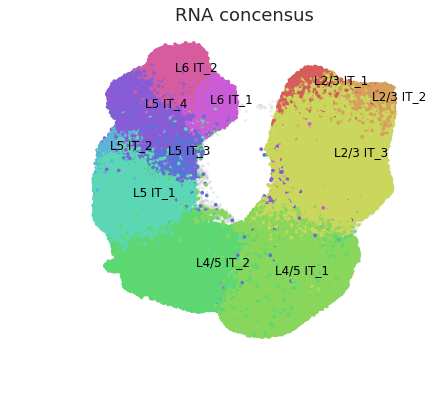

In [85]:
show_labels = True
tc = 'RNA concensus'
cond = df_info[tc].isnull()

fig, ax = plt.subplots(figsize=(6, 6))
# background
ax.scatter(df_info.loc[cond, tx].values, 
           df_info.loc[cond, ty].values, 
           s=3,
           alpha=0.2,
           rasterized=True,
           color='silver')

# get uniq colors for joint clusters  
tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', tc
df_plot = df_info[~cond]
cluster_centroids = (df_plot[['tsne_x_joint', 'tsne_y_joint', tc]].groupby([tc]).median())
clsts = np.sort(df_plot[tc].unique())
clsts_pt = [clst for clst in clsts if pt_pattern.match(clst) and 'Car3' not in clst]
colors = snmcseq_utils.gen_colors(len(clsts_pt))
palette = {clst: color for clst, color in zip(clsts_pt, colors)}
for clst in clsts:
    if clst not in clsts_pt:
        palette[clst] = 'lightgray'
        
# plot joint cluster
snmcseq_utils.plot_tsne_labels_ax(df_plot, ax, tx, ty, tc, 
                                  t_xlim=None, t_ylim=None,
                                  rasterized=True,
                                  legend_mode=-1,
                                  kw_colors=palette,
                                  s=5,
                                 )
# cluster labels
if show_labels:
    for clst, centroid in cluster_centroids.iterrows():
        if clst in clsts_pt:
            ax.text(centroid.values[0], 
                    centroid.values[1], 
                    str(clst),
                    color='black', 
                    fontsize=12,
                   )

ax.set_title(tc) 
ax.axis('off')

fig.savefig(output_figures.format('plot_RNAconcensus-labeled', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()

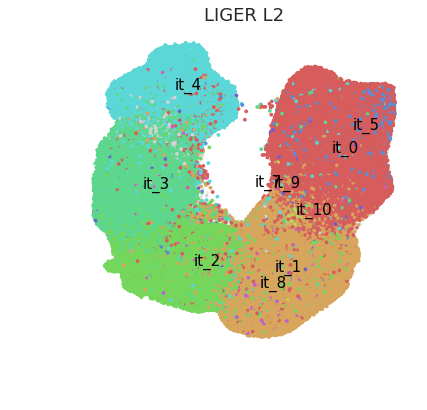

In [90]:
show_labels = True
tc = 'LIGER_level2'
cond = df_info[tc].isnull()

fig, ax = plt.subplots(figsize=(6, 6))
# background
ax.scatter(df_info.loc[cond, tx].values, 
           df_info.loc[cond, ty].values, 
           s=3,
           alpha=0.2,
           rasterized=True,
           color='silver')

# get uniq colors for joint clusters  
tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', tc
df_plot = df_info[~cond]
cluster_centroids = (df_plot[['tsne_x_joint', 'tsne_y_joint', tc]].groupby([tc]).median())
clsts = np.sort(df_plot[tc].unique())
clsts_pt = [clst for clst in clsts if pt_pattern.match(clst) and 'it_6' not in clst]
colors = snmcseq_utils.gen_colors(len(clsts_pt))
palette = {clst: color for clst, color in zip(clsts_pt, colors)}
for clst in clsts:
    if clst not in clsts_pt:
        palette[clst] = 'lightgray'
        
# plot joint cluster
snmcseq_utils.plot_tsne_labels_ax(df_plot, ax, tx, ty, tc, 
                                  t_xlim=None, t_ylim=None,
                                  rasterized=True,
                                  legend_mode=-1,
                                  kw_colors=palette,
                                  s=5,
                                 )
# cluster labels
if show_labels:
    for clst, centroid in cluster_centroids.iterrows():
        if clst in clsts_pt:
            ax.text(centroid.values[0], 
                    centroid.values[1], 
                    str(clst),
                    color='black', 
                    fontsize=15,
                   )

ax.set_title('LIGER L2') 
ax.axis('off')

fig.savefig(output_figures.format('plot_LIGER_L2-labeled', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()

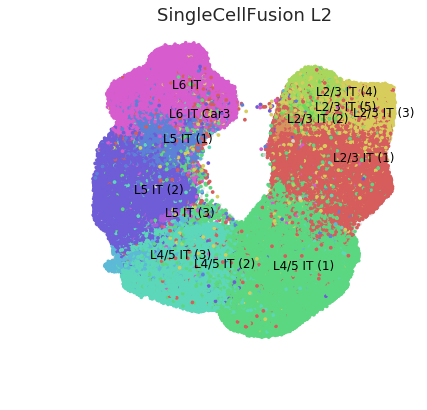

In [92]:
show_labels = True
tc = 'SCF_round3'
cond = df_info[tc].isnull()

fig, ax = plt.subplots(figsize=(6, 6))
# background
ax.scatter(df_info.loc[cond, tx].values, 
           df_info.loc[cond, ty].values, 
           s=3,
           alpha=0.2,
           rasterized=True,
           color='silver')

# get uniq colors for joint clusters  
tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', tc
df_plot = df_info[~cond]
cluster_centroids = (df_plot[['tsne_x_joint', 'tsne_y_joint', tc]].groupby([tc]).median())
clsts = np.sort(df_plot[tc].unique())
clsts_pt = [clst for clst in clsts if pt_pattern.match(clst)]
colors = snmcseq_utils.gen_colors(len(clsts_pt))
palette = {clst: color for clst, color in zip(clsts_pt, colors)}
for clst in clsts:
    if clst not in clsts_pt:
        palette[clst] = 'lightgray'
        
# plot joint cluster
snmcseq_utils.plot_tsne_labels_ax(df_plot, ax, tx, ty, tc, 
                                  t_xlim=None, t_ylim=None,
                                  rasterized=True,
                                  legend_mode=-1,
                                  kw_colors=palette,
                                  s=5,
                                 )
# cluster labels
if show_labels:
    for clst, centroid in cluster_centroids.iterrows():
        if clst in clsts_pt:
            ax.text(centroid.values[0], 
                    centroid.values[1], 
                    str(clst),
                    color='black', 
                    fontsize=12,
                   )

ax.set_title('SingleCellFusion L2') 
ax.axis('off')

fig.savefig(output_figures.format('plot_SCF-labeled', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()

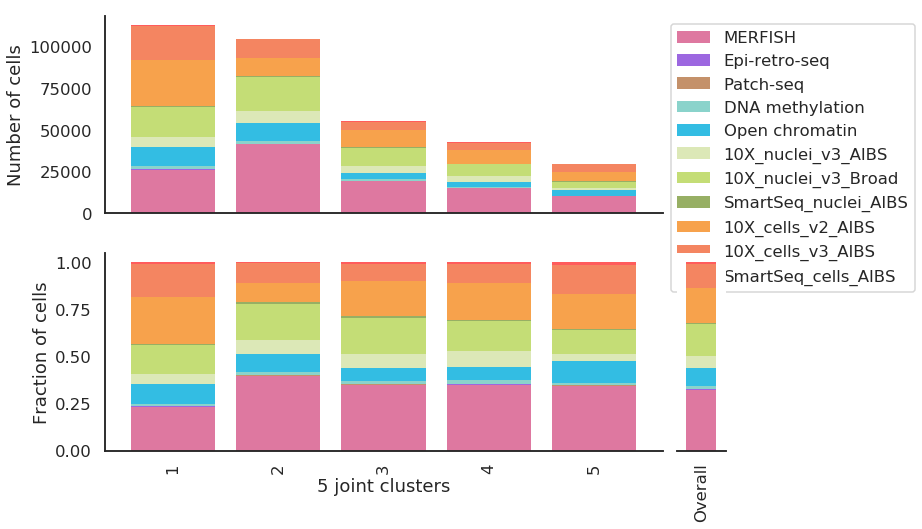

In [68]:
# histograms
with sns.axes_style('white', {"patch.edgecolor": "black", 'patch.force_edgecolor': False,}):
    fig, axs = plt.subplots(2, 1, figsize=(10,4*2))
    ax = axs[0]
    hist[mods_ordered[::-1]].rename(index=mod_names, columns=mod_names).plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, 
                  color=[val for key, val in mod_colors.items()][::-1], # this controls mod_colors
                 )
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_ylabel('Number of cells')
    ax.set_xlabel('')
    ax.set_xticklabels([])
    

    ax = axs[1]
    hist_frac[mods_ordered[::-1]].rename(index=mod_names, columns=mod_names).plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                  color=[val for key, val in mod_colors.items()][::-1], # this controls mod_colors
                 )
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('Fraction of cells')
    ax.set_xlabel('{} joint clusters'.format(len(hist)))
#     ax.set_xticklabels([])
    
#     ax = fig.add_axes([.95, .5, .05, .4])
    left_x, left_y, width, height = ax.get_position().bounds
    ax = fig.add_axes((left_x+width+0.2*(1-(left_x+width)), left_y, 0.3*(1-width), height))
    ((hist_mod/hist_mod.sum()).loc[mods_ordered[::-1]].to_frame().T.rename({0: 'Overall'}, axis=0)
                      .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                      color=[val for key, val in mod_colors.items()][::-1]) # this controls mod_colors
    )
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
#     fig.tight_layout()
    fig.savefig(output_figures.format('plot_4_hist', 'pdf'), bbox_inches='tight')
    plt.show()

In [69]:
mods_ordered2 = mods_ordered
# mods_ordered2 = ['']
# mods_ordered
# mods_ordered2 = [
#      'snatac_gene',
#      'epi_retro',
#      'snmcseq_gene',
#      'patchseq',
#      'smarter_nuclei',
#      '10x_nuclei_v3_macosko',
#      '10x_nuclei_v3',
#     'smarter_cells',
#      '10x_cells_v3',
#      '10x_cells_v2',
#      'merfish',
# ]

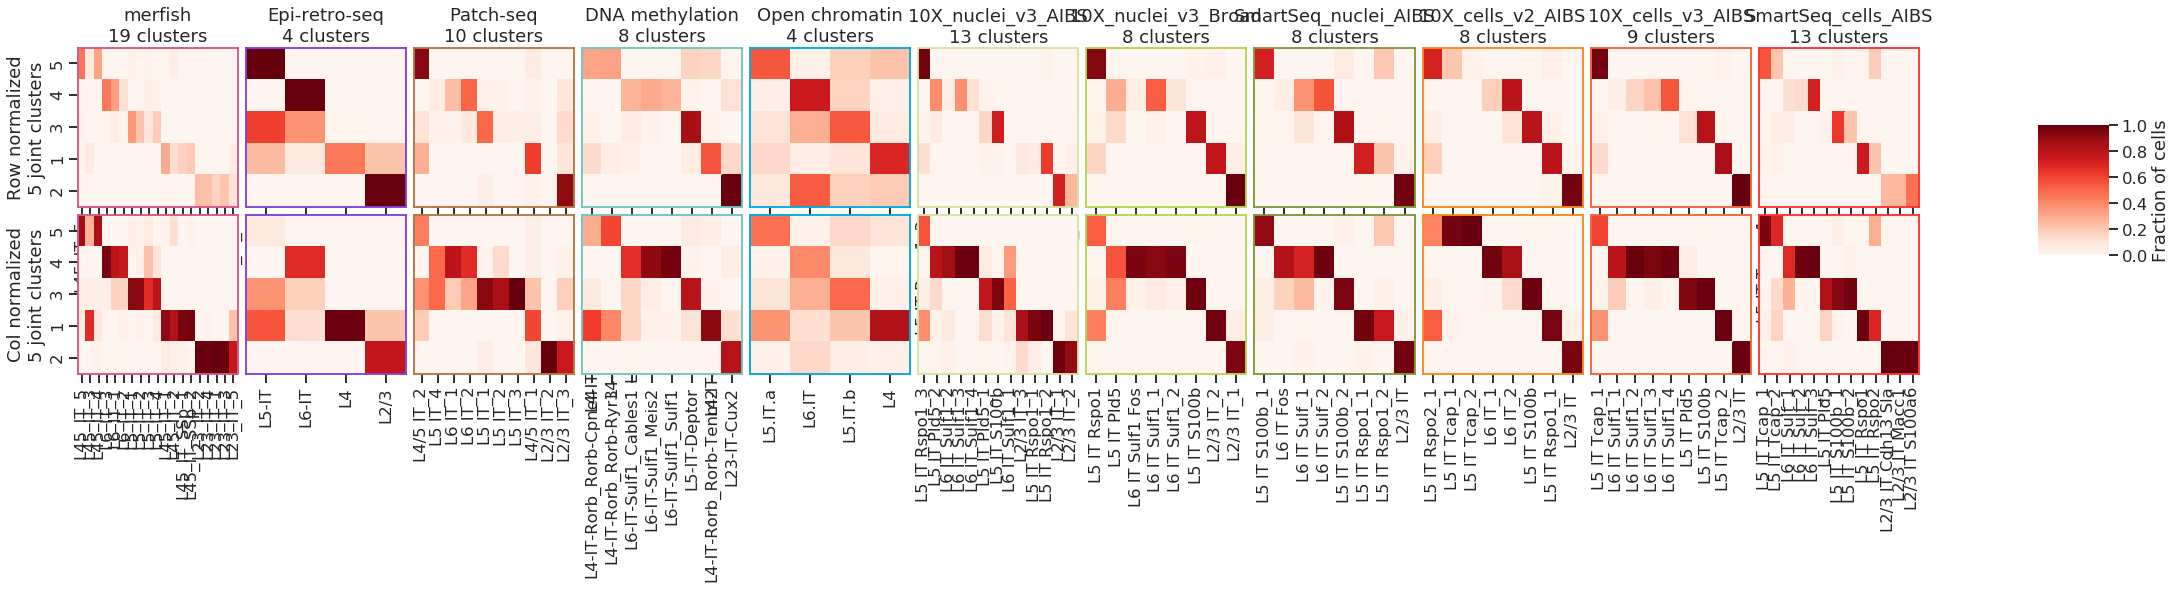

In [70]:
# confusion matrix

nx = len(mods_ordered2)
ny = 2
heatmap_kws = {
    'xticklabels': True, 
    'yticklabels': True,
    'vmin': 0, 
    'vmax': 1,
    'cmap': 'Reds',
}

cbar_kws = {
    'orientation': 'vertical', 
    'label': 'Fraction of cells',
}

with sns.plotting_context('talk'):
    fig, axs = plt.subplots(ny, nx, figsize=(3*nx, 3*ny))
    axs = axs.T
    cbar_ax = fig.add_axes([0.95, 0.4, 0.03, 0.3])
    njoint_clusters = len(df_info[joint_cluster].unique())
    for i, (mod, ax) in enumerate(zip(mods_ordered2[::-1], axs)):
        conf_mat = pd.crosstab(df_info.loc[((df_info['modality']==mod) & (pt_cond)), 'annot'], 
                               df_info.loc[((df_info['modality']==mod) & (pt_cond)), joint_cluster],
                              )
        # normalize each joint cluster
        conf_mat_njoint = conf_mat.divide(conf_mat.sum(axis=0), axis=1)
        # normalize each orig cluster
        conf_mat_norig = conf_mat.divide(conf_mat.sum(axis=1), axis=0)

        # plot normalized by joint 
        if i == 0:
            # order both row and col
            _X = conf_mat_njoint
            _rX, ri, rc = snmcseq_utils.diag_matrix(_X.values, _X.index.values, _X.columns.values, threshold=0.1)
            _rX = pd.DataFrame(_rX, index=ri, columns=rc)
            g = sns.heatmap(_rX.T, 
                        cbar=True,
                        cbar_kws=cbar_kws,
                        cbar_ax=cbar_ax,
                        ax=ax[0],
                        **heatmap_kws,
                       )
            g.axes.set_title('{}\n{} clusters'.format(mod, _rX.shape[0]))
            g.axes.set_ylabel('Row normalized\n{} joint clusters'.format(njoint_clusters))

            order_joint = _rX.columns.values # Will be fixed for all integrated clusters 
            order_orig = _rX.index.values # Will be fixed for the mod clusters  
        else:
            # order just row (orig)
            _X = conf_mat_njoint.loc[:, order_joint].fillna(0)
            _rX, ri, rc = snmcseq_utils.diag_matrix_rows(_X.values, _X.index.values, _X.columns.values)
            _rX = pd.DataFrame(_rX, index=ri, columns=rc)
            g = sns.heatmap(_rX.T, 
                        cbar=False,
                        ax=ax[0],
                        **heatmap_kws,
                       )
            ax[0].set_yticks([])
            ax[0].set_yticklabels([])
            g.axes.set_title('{}\n{} clusters'.format(settings[mod].name, _rX.shape[0]))
            g.axes.set_ylabel('')

            order_orig = _rX.index.values # Will be fixed for the mod clusters  
        # bounding box
        for _, spine in g.axes.spines.items():
            spine.set_visible(True)
            spine.set_color(settings[mod].color)
#             spine.set_linewidth(3)

        # plot normalized by orig (according to the axis of normalized by joint) 
        _X = conf_mat_norig.loc[order_orig, order_joint].fillna(0)
        g = sns.heatmap(_X.T, 
                    cbar=False,
                    ax=ax[1],
                    **heatmap_kws,
                   )
        
        if i == 0:
            g.axes.set_xlabel('')
            g.axes.set_ylabel('Col normalized\n{} joint clusters'.format(njoint_clusters))
        else:
            ax[1].set_yticks([])
            ax[1].set_yticklabels([])
            g.axes.set_xlabel('')
            g.axes.set_ylabel('')
        # bounding box
        for _, spine in g.axes.spines.items():
            spine.set_visible(True)
            spine.set_color(settings[mod].color)
#             spine.set_linewidth(3)
            
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.savefig(output_figures.format('plot_5_confmat', 'pdf'), bbox_inches='tight')
    plt.show()

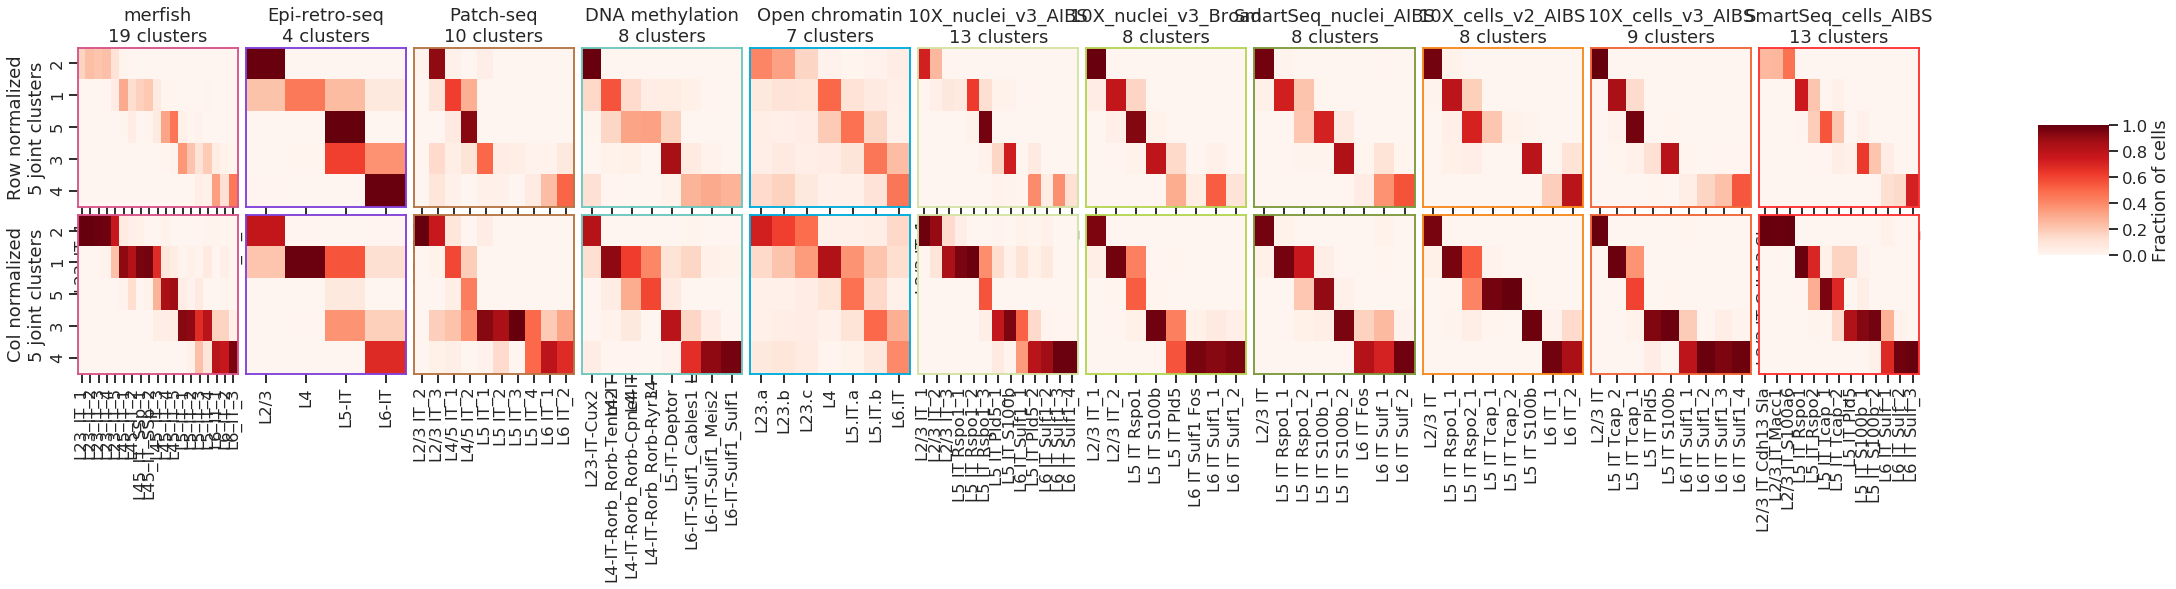

In [100]:

# confusion matrix

nx = len(mods_ordered2)
ny = 2
heatmap_kws = {
    'xticklabels': True, 
    'yticklabels': True,
    'vmin': 0, 
    'vmax': 1,
    'cmap': 'Reds',
}

cbar_kws = {
    'orientation': 'vertical', 
    'label': 'Fraction of cells',
}

order_joint = [2, 1, 5, 3, 4,]

with sns.plotting_context('talk'):
    fig, axs = plt.subplots(ny, nx, figsize=(3*nx, 3*ny))
    axs = axs.T
    cbar_ax = fig.add_axes([0.95, 0.4, 0.03, 0.3])
    njoint_clusters = len(df_info[joint_cluster].unique())
    for i, (mod, ax) in enumerate(zip(mods_ordered2[::-1], axs)):
        conf_mat = pd.crosstab(df_info.loc[((df_info['modality']==mod) & (pt_cond)), 'annot'], 
                               df_info.loc[((df_info['modality']==mod) & (pt_cond)), joint_cluster],
                              )
        # normalize each joint cluster
        conf_mat_njoint = conf_mat.divide(conf_mat.sum(axis=0), axis=1)
        # normalize each orig cluster
        conf_mat_norig = conf_mat.divide(conf_mat.sum(axis=1), axis=0)

        # plot normalized by joint 
        if i == 0:
            # order both row and col
            _X = conf_mat_njoint.loc[:, order_joint].fillna(0)
#             _X = conf_mat_njoint
#             _rX, ri, rc = snmcseq_utils.diag_matrix(_X.values, _X.index.values, _X.columns.values, threshold=0.1)
            _rX, ri, rc = snmcseq_utils.diag_matrix_rows(_X.values, _X.index.values, _X.columns.values)
            _rX = pd.DataFrame(_rX, index=ri, columns=rc)
            g = sns.heatmap(_rX.T, 
                        cbar=True,
                        cbar_kws=cbar_kws,
                        cbar_ax=cbar_ax,
                        ax=ax[0],
                        **heatmap_kws,
                       )
            g.axes.set_title('{}\n{} clusters'.format(mod, _rX.shape[0]))
            g.axes.set_ylabel('Row normalized\n{} joint clusters'.format(njoint_clusters))

#             order_joint = _rX.columns.values # Will be fixed for all integrated clusters 
            order_orig = _rX.index.values # Will be fixed for the mod clusters  
        else:
            # order just row (orig)
            _X = conf_mat_njoint.loc[:, order_joint].fillna(0)
            _rX, ri, rc = snmcseq_utils.diag_matrix_rows(_X.values, _X.index.values, _X.columns.values)
            _rX = pd.DataFrame(_rX, index=ri, columns=rc)
            g = sns.heatmap(_rX.T, 
                        cbar=False,
                        ax=ax[0],
                        **heatmap_kws,
                       )
            ax[0].set_yticks([])
            ax[0].set_yticklabels([])
            g.axes.set_title('{}\n{} clusters'.format(settings[mod].name, _rX.shape[0]))
            g.axes.set_ylabel('')

            order_orig = _rX.index.values # Will be fixed for the mod clusters  
        # bounding box
        for _, spine in g.axes.spines.items():
            spine.set_visible(True)
            spine.set_color(settings[mod].color)
#             spine.set_linewidth(3)

        # plot normalized by orig (according to the axis of normalized by joint) 
        _X = conf_mat_norig.loc[order_orig, order_joint].fillna(0)
        g = sns.heatmap(_X.T, 
                    cbar=False,
                    ax=ax[1],
                    **heatmap_kws,
                   )
        
        if i == 0:
            g.axes.set_xlabel('')
            g.axes.set_ylabel('Col normalized\n{} joint clusters'.format(njoint_clusters))
        else:
            ax[1].set_yticks([])
            ax[1].set_yticklabels([])
            g.axes.set_xlabel('')
            g.axes.set_ylabel('')
        # bounding box
        for _, spine in g.axes.spines.items():
            spine.set_visible(True)
            spine.set_color(settings[mod].color)
#             spine.set_linewidth(3)
            
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.savefig(output_figures.format('plot_5_confmat', 'pdf'), bbox_inches='tight')
    plt.show()

In [97]:
metas['snatac_gene']['cluster'].unique()

array(['L23.b', 'L5.IT.b', 'L4', 'L5.IT.a', 'L23.a', 'L6.IT', 'L23.c'], dtype=object)